#### Introduction ####

This notebook deals with Semantic Segmentation, or pixel-wise segmentation for finding defects in a given steel image. The data is take from the [Severstal Steel Defect Detection Competition](https://www.kaggle.com/competitions/severstal-steel-defect-detection). I want to first let you know that this is NOT aimed towards the same task from the competition. In the competition, there are 4 classes of defects, and there are many images with no defects present. In this notebook, I have purposely taken only defect class 4, and all the images that I will deal with HAVE class 4 defect in it. I have used the U-Net Architecture, with some modifications.

The references/resources for this project are the following:  
1] [U-Net Paper](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical): This is a research paper titled: *U-Net: Convolutional Networks for Biomedical Image Segmentation*         
2] [PyTorch Implementation of U-Net](https://nn.labml.ai/unet/index.html): This is a helpful resource for the coding details of U-Net using PyTorch. The link was given at the first U-Net Paper link.   
3] [U-Net for Brain MRI](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/) : This is where I get the modified U-Net Architecture that I used for this project.     
4] [Loss Function Library - Keras & PyTorch](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook#Focal-Loss) : This is Kaggle Notebook, from which I brought the *Dice - BCE Loss* Function.  

Let's get started.

2022/11/29 Updated: details of how the visualization function at the end works (feedback by [The Devastator](https://www.kaggle.com/thedevastator))

**Table of Contents**

1. Data Processing
2. Model Building and Training
3. Prediction on the Test Set

## 1. Data Processing ##

📌 I load the libraries to be used for the project.

In [2]:
# Подключаемые библиотеки

# библиотеки для работы с массивами данных
import pandas as pd
import numpy as np
# библиотеки для визуализации данных
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

# библиотеки машинного обучения PyTotch
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

# дополнительные библиотеки
from tqdm import tqdm
from time import sleep

📌 Loading data

In [3]:
# загрузка данных с изображениями
folder_path = '/kaggle/input/severstal-steel-defect-detection/'
images_path = folder_path + 'train_images/' 

tab = pd.read_csv(folder_path+'train.csv')
c = 4
tab = tab[tab['ClassId'] == c].copy()
tab = tab.reset_index().drop('index', axis = 1)
image_list = tab['ImageId'].unique()
tab

,ImageId,ClassId,EncodedPixels
0,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...
...,...,...,...
796,fda1a539d.jpg,4,128621 3 128876 8 129131 11 129386 13 129641 1...
797,fdb7c0397.jpg,4,155020 6 155268 16 155516 27 155764 37 156012 ...
798,feec56162.jpg,4,99346 1 99602 1 99858 1 100113 2 100369 3 1006...
799,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...


📌 The following is a function that converts **'running pixels'** to a 256 x 1600 matrix (same as image size), that shows the location of defect in an image (0: non-defect pixel, 1: defect pixel). Description of the running pixels can be found [here](https://www.kaggle.com/competitions/severstal-steel-defect-detection/overview/evaluation).

In [4]:
# функция для определения местоположения дефекта
def pix_to_mat(pixels, h , w):
    p_list = pixels.split()
    start = np.array(p_list[0::2]).astype(int)
    length = np.array(p_list[1::2]).astype(int)
    n = len(start)
    m = np.zeros(h*w)
    for i in range(n):
        m[start[i] - 1 : start[i] - 1 + length[i]] = 1
    m = m.reshape(w,h).T
    return m

Following is the verification that this works.

In [5]:
#Verification

h = 4
w = 5
pixels = '1 3 6 3 11 1 18 3'
pix_to_mat(pixels, h, w)

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 1.],
       [0., 1., 0., 0., 1.]])

📌 Following are some examples of the defects. Three images are given below. Each image is followed by its copy, with green area as the defect area. Each image is **256(height) by 1600(width)**, thus amounting to 409600 pixels. I have also printed the number of pixels in each image that are counted as defective.

Number of Defect Pixels: 85785 out of 409600 pixels.


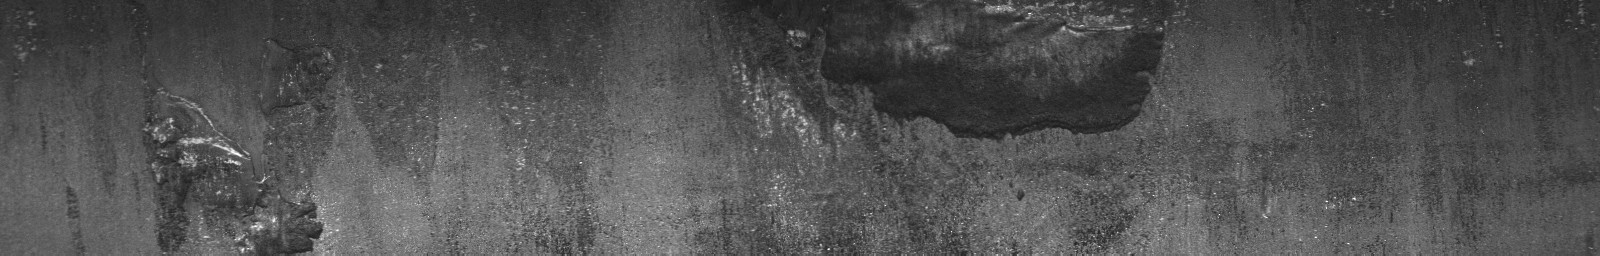

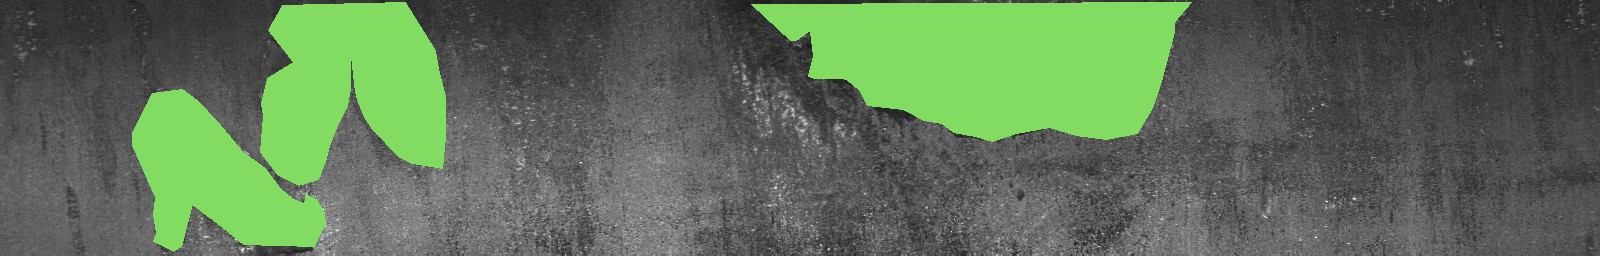

Number of Defect Pixels: 25346 out of 409600 pixels.


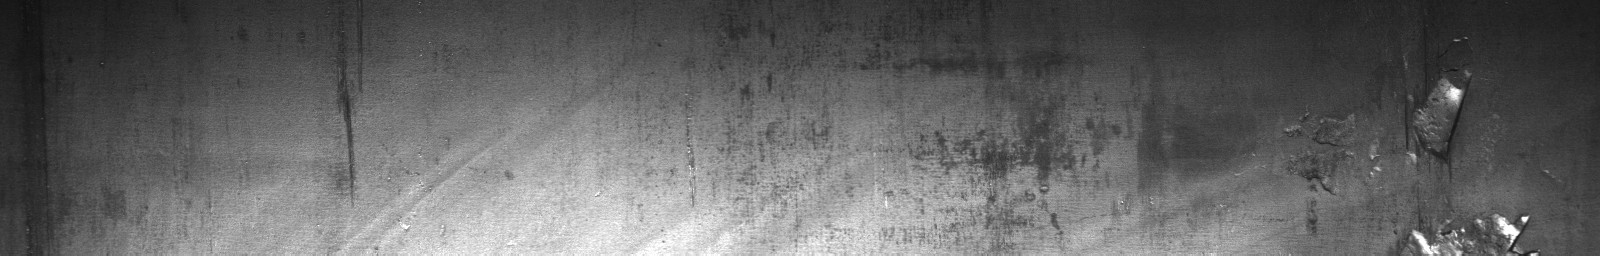

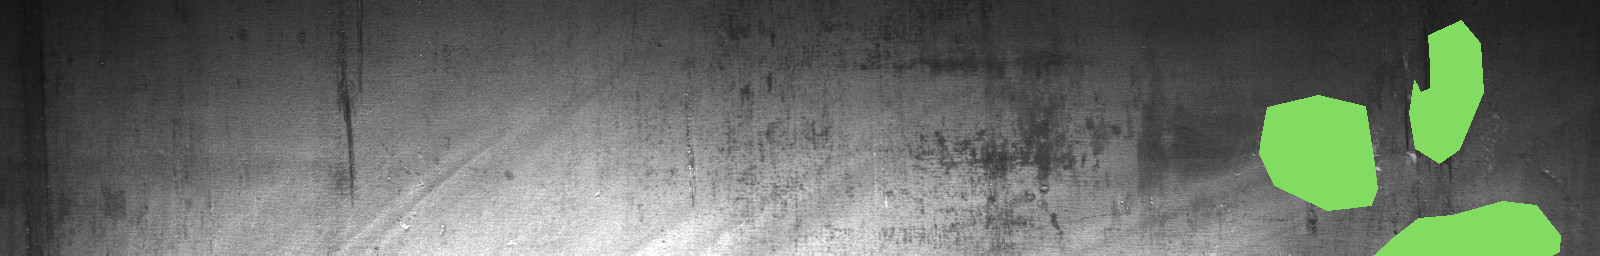

Number of Defect Pixels: 5762 out of 409600 pixels.


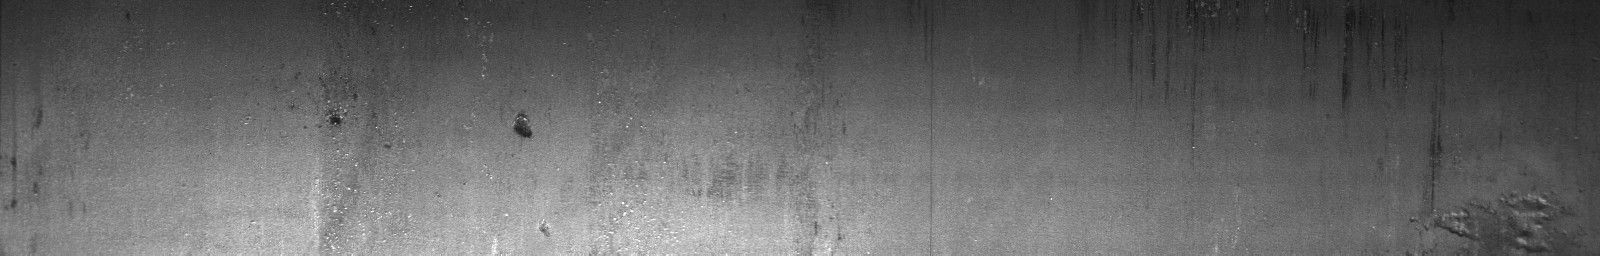

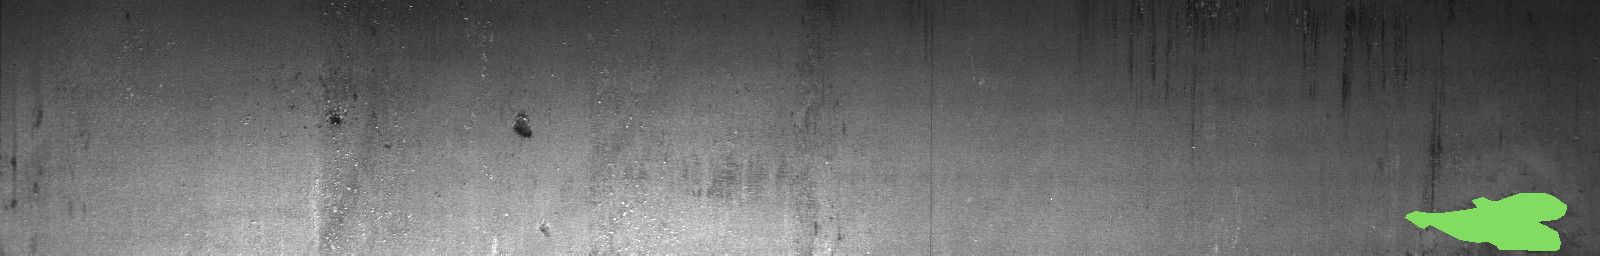

In [6]:
# Функция для отображения областей с дефектами на изображениях
def imageshow(imageid):
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    img = mpimg.imread(images_path + imageid).transpose(-1,0,1)
    img[0, image_mask == 1] = 130
    img[1, image_mask == 1] = 220
    img[2, image_mask == 1] = 97
    print(f'Number of Defect Pixels: {round(image_mask.sum())} out of {256*1600} pixels.')
    display(Image.open(images_path + imageid))
    display(Image.fromarray(img.transpose(1,2,0)))

#np.random.seed(23)

for i in range(3):
    imageid = np.random.choice(image_list)
    imageshow(imageid)

📌 There are a total of 801 images, which are split into 741, 30, 30 as train, validation, and test sets.

In [7]:
# разделяем набор данных на три набора: тренировочный, валидный и тестовый
# np.random.seed(39)
print(len(image_list)) # всего имеем 801 изображение

# количество изображений для валидации и тестирования
n = 30

# случайным образом выберем 30 изображений для валидации
val = list(np.random.choice(image_list, n, replace = False))
train = list(set(image_list) - set(val))
# случайным образом выберем 30 изображений для тестирования
test = list(np.random.choice(train, n, replace = False))
train = list(set(train) - set(test)) # оставшиеся изображения составят тренировочный набор 
# вывод количества изображений в каждом блоке
for l in train, val, test:
    print(len(l))
    
print(test[:2])

801
741
30
30
['6ec88b7f7.jpg', '72a7ff0db.jpg']


📌**Crops**
As I mentioned before, each image is <ins>256 x 1600</ins>. What I am going to do is, for each of the train, validation, test set, I am going to take multiple crops within each image. **Each crop** will be of size **256 x 256**. Now, that means that the whole range of height will be cropped, but horizontally, the width will have a starting index, that stretches rightward by 256 pixels. Thus, if I took 450 as the index, then 450~705 would be the range of indices that would be cropped from the width dimension. You can see below that I have taken 33 crop locations from the train set, and 12 crop locations from each of the validation and test sets.

In [9]:
# Обрезка входных изображений (256 х 1600) на снимки 256 х 256
# На вход U-Net должны подаваться изображения 256 х 256

# создание массивов с позициями обрезки изображений
train_pos = []
valtest_pos = []

for i in range(0,32):
    train_pos.append(i * 40)
    
train_pos.append(1344)

for j in range(0,11):
    valtest_pos.append(j * 130)

valtest_pos.append(1344)

print(len(train_pos))
print(len(valtest_pos))

33
12


Now, I'm not going to take all of the crops of the images. I will specifically choose cropped images that contain more than 12000 (for train) or 5000 (for val and test) pixels that have defects. Thus we end up with train: 4661 crops, val: 102, and test: 121. I have stored the imageid with its 'cropping location(on the width axis)' as 'expanded lists'. These lists will be used as part of the dataloaders.

In [10]:
# обрезка изображений
train_expanded = []
val_expanded = []
test_expanded = []

for imageid in train:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in train_pos:
        
        if image_mask[:,p:p+256].sum() > 12000:
            
            train_expanded.append(imageid + '_' + str(p))
            
for imageid in val:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            val_expanded.append(imageid + '_' + str(p))

for imageid in test:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            test_expanded.append(imageid + '_' + str(p))
            
print(len(train_expanded))
print(len(val_expanded))
print(len(test_expanded))

4665
98
112


I have used **dataset-wide** normalization of the images. The values have been pre-computed and copy-pasted below in the code as MEAN and STD. Firstly, the images in the dataset, though in 3 dimensions, are actually one-dimensional (gray-scale?). The R, G, B channels all have the same values. So firstly, you can reduce the image from a **3 x 256 x 256** to a **1 x 256 x 256** dimension. Each image then has a mean pixel value. This mean is calculated over the entire dataset (actually just the train), and then the mean of those means is computed, which is the 'MEAN' value below. Then, STD is calculated by calculating the following:

$$STD = \sqrt{\frac{1}{n_{t}} \sum_{i=1}^{n_{t}} \frac{1}{256 \times 256} \sum_{j=1}^{all pixels} (x_{j} - MEAN)^2}$$

where $n_{t}$ is the number of train images.

In the code, there is a transformation called 'ToTensor()' which scales the image from 0-255 to 0-1 scale, so we should keep that in mind when we compute. In addition to having more crops, for the training data, each image will randomly be vertically flipped, and then independently, randomly be horizontally flipped. The Custom Datasets and Dataloaders are created for train, val, and test.

In [11]:
# Нормализация обрезанных изображений

# Параметры нормализации
MEAN =  99.45881939063021 # среднее значение пикселя по train data
STD =  50.285401061795476 # стандартное отклонение по train data

t1 = transforms.ToTensor() # перевод изображения в тензор
vf = transforms.RandomVerticalFlip() # случайный вертикальный поворот
hf = transforms.RandomHorizontalFlip() # случайный горизонтальный поворот

# класс нормализации изображений
class data(Dataset):
    
    def __init__(self, list_expanded, data_type): 
                    #data_type: 'train', 'val', or 'test.
        
        self.list_expanded = list_expanded
        self.data_type = data_type
    
    def __len__(self):
        
        return len(self.list_expanded)
    
    def __getitem__(self, idx):
        
        imageid = self.list_expanded[idx].split('_')[0]
        p =  int(self.list_expanded[idx].split('_')[1])
        image = Image.open(images_path + imageid)

        m = MEAN/255
        s = STD/255
        
        # нормализация изображений по параметрам m и s
        t2 = transforms.Normalize(mean = m , std = s)
        
        # переводим изображение RGB в одноканальное
        img_tensor = t2(t1(image)[0].unsqueeze(0))

        X_ = img_tensor[:, :, p : p + 256]

        pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
        image_mask = pix_to_mat(pixels, 256, 1600)
        y_ = torch.tensor(image_mask).unsqueeze(0)[:, :, p : p + 256]
        
        if self.data_type == 'train':
            
            if np.random.randint(1,3) == 1:
                X_ = vf(X_)  
                y_ = vf(y_)

            if np.random.randint(1,3) == 1:
                X_ = hf(X_)
                y_ = hf(y_)

        return X_, y_

torch.manual_seed(6)
    
traindata = data(train_expanded, 'train')
valdata = data(val_expanded, 'val')
testdata = data(test_expanded, 'test') 

# Формирование загрузчиков данных
trainloader = DataLoader(traindata, batch_size = 16, shuffle = True)
valloader = DataLoader(valdata, batch_size = len(val_expanded))
testloader = DataLoader(testdata, batch_size = len(test_expanded))

## 2. Model Building and Training ##

For Training, **Dice-BCE Loss** will be used. This is a combined-loss with Binary Cross Entropy and Dice Loss. This will be used for training the model.

For evaluation metric, I will be taking the **mean Dice-Coefficient** for all of the validation (or test) examples. A Dice coefficient for a given two images, say A: predictions, and B: true values, is:

$$ \frac {2 |A \cap B|} {|A| + |B|} $$


Take the following as an example:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

for i in range(2):
    axes[i].set_xlim(0, 5)
    axes[i].set_ylim(0, 5)
    axes[i].grid(True)

axes[0].plot()
rect1 = matplotlib.patches.Rectangle((1,1), 3, 2, color='lightblue')
rect2 = matplotlib.patches.Rectangle((2,1), 1, 3, color='salmon')
rect3 = matplotlib.patches.Rectangle((3,1), 2, 1, color='salmon')
axes[0].add_patch(rect1)
axes[1].add_patch(rect2)
axes[1].add_patch(rect3)
plt.show()

Say the that an image is 5 x 5 = 25 pixels in total. The blue squares are prediction. The red squares are true locations of defects. In this case, the Dice - Coefficient for this pair of images would be:

$$\frac{2 \times intersection}{Blue + Red} = \frac{2 \times 3}{6 + 5} = 0.545$$

The evaluation metric is the mean of Dice Coefficients computed each for pair of a prediction and a true values (matrices).

The following code has been taken from the notebook previously mentioned.

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

This is a modified version of the U-Net Architecture, where the features of channels for the convolutions are smaller, and the same paddings are applied. The skip connections will not be cropped.

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    
print(device)

class DoubleConvs(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.ic = in_channels
        self.oc = out_channels
        self.conv1 = nn.Conv2d(self.ic, self.oc, kernel_size = 3, padding = 1) 
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.oc, self.oc, kernel_size = 3, padding = 1) 
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        return x

class UNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.cs = [1,32,64,128,256,512]
        self.DownConvs = nn.ModuleList(DoubleConvs(self.cs[i],self.cs[i+1]) for i in range(4))
        self.DownPools = nn.ModuleList(nn.MaxPool2d(kernel_size = 2, stride = 2) for i in range(4))
        self.Bottleneck = DoubleConvs(256,512)
        self.UpConvs = nn.ModuleList(DoubleConvs(self.cs[i], self.cs[i-1]) for i in range(5,1,-1))
        self.Ups = nn.ModuleList(nn.ConvTranspose2d(self.cs[i], self.cs[i-1], kernel_size = 2, stride = 2) for i in range(5,1,-1))
        self.FinalConv = nn.Conv2d(32, 1, kernel_size = 3, padding = 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        skip_connections = []
            
        for i in range(4):
            x = self.DownConvs[i](x)
            skip_connections.append(x)
            x = self.DownPools[i](x)
            
        x = self.Bottleneck(x)
        
        skip_connections.reverse()
        
        for i in range(4):
            x = self.Ups[i](x)
            x = torch.cat([x, skip_connections[i]], dim = 1)
            x = self.UpConvs[i](x)
        
        x = self.FinalConv(x)
        x = self.Sigmoid(x)
        
        return x

torch.manual_seed(5)
model = UNet().to(device)

loss_fn = DiceBCELoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

W = [k for k in model.state_dict().keys() if '.weight' in k] #Convolution Weights
B = [k for k in model.state_dict().keys() if '.bias' in k] #Convolution Biases

for w in W:
    nn.init.kaiming_uniform_(model.state_dict()[w], a=0, mode='fan_in', nonlinearity='relu')
    
for b in B:
    nn.init.zeros_(model.state_dict()[b])

📌 Four functions are defined below: Overfitting a minibatch function, validation and test(which return the evaluation metrics for validation and test sets), and train (which trains a given number of epochs).

In [ ]:
# функция для вычисления ошибки на валидных данных
# Функция потерь - Dice coeff. + BCE(Binary Cross Entropy)
def validation_loss():

    V_loss = 0

    X, y = next(iter(valloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(valdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            loss = loss_fn(y_pred, y[n].to(torch.float32).to(device))
            V_loss += loss.item()
            
    model.train()

    return V_loss / len(valdata)

# функция получения точности на валидных данных
# метрика - Dice coeff.
def validation(th): # th - это порог для получения двоичного вывода (1:defect, 0:no defect)

    V_dice = 0

    X, y = next(iter(valloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(valdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            v_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            V_dice += v_dice
            
    model.train()

    return V_dice / len(valdata)

# функция для получения точности на тестовых данных
# метрика - Dice coeff.
def test(th):

    T_dice = 0

    X, y = next(iter(testloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(testdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            t_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            T_dice += t_dice

    return T_dice / len(testdata)

In [ ]:
def train(epochs):
    
    model.train()# переводим модель в тренировочный режим
    
    # результатом работы функции будут эти три тензора
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    for i in range(epochs):
        
        L = 0 # общее значение ошибки на данной эпохе
        # в каждом батче имеем 16 пар обрезанных изображений: X - входное изображение, Y - изображение с разметкой;
        for batch, (X,y) in tqdm(enumerate(trainloader)):
            
            # переводим все вычисления на GPU
            X, y = X.to(device), y.to(torch.float32).to(device)
            # Прогоняем входную обрезку через модель
            y_pred = model(X)
            # рассчитываем значение loss-функции(ошибки)
            loss = loss_fn(y_pred, y)
            # обнуляем оптимизатор, чтобы не копить ошибку
            optimizer.zero_grad()
            # считаем градиенты
            loss.backward()
            # делаем градиентный шаг в оптимизаторе
            optimizer.step()
            
            L += loss.item()# расссчитываем значение ошибки по данной эпохе
    
        # значение ошибки для тренировочных данных на текущей эпохе
        train_loss = L/len(trainloader)
        train_loss_history.append(train_loss)
        
        # значение ошибки для валидационных данных на текущей эпохе
        val_loss = validation_loss()
        val_loss_history.append(val_loss)
        
        # значение точности на валидационных данных
        val_accuracy = validation(0.5)
        val_accuracy_history.append(val_accuracy)
        
        print(f'epoch {i+1}, train_loss(dice-bce):{train_loss}, val_loss(dice-bce):{val_loss}, val_accuracy(dice_coef):{val_accuracy}')
    
    return train_loss_history, val_loss_history, val_accuracy_history

In [ ]:
losses_train = {}
losses_val = {}
val_accuracy = {}


# Тренируем модель на 11 эпохах, запоминая результаты ошибок
losses_train['losses_train'], losses_val['losses_val'], val_accuracy['val_accuracy']  = \
    train(11)

In [ ]:
# распечатываем графики ошибок(loss функция - это DICE+BCE)

plt.grid(visible=True, color='0.5')

# Train
for experiment_id in losses_train.keys():
    plt.plot(losses_train[experiment_id], label=experiment_id)
plt.legend()
plt.title('Losses');

# Validation
for experiment_id in losses_val.keys():
    plt.plot(losses_val[experiment_id], label=experiment_id)
plt.legend()
plt.title('Losses');

In [ ]:
# Распечатываем график точности на валидационных данных

# Validation
for experiment_id in val_accuracy.keys():
    plt.plot(val_accuracy[experiment_id], label=experiment_id)
plt.legend()
plt.grid(visible=True, color='0.5')
plt.title('Accuracy');

📌 Initial Validation Loss:

In [ ]:
#validation(0.5)

📌 Model is trained for 10 epochs.

In [ ]:
#train(10)
test(0.5)

## 3. Prediction on the Test Set ##

Below is the val_test_show function, which randomly samples an image from validation or test (of your choice) with a given threshold for binary prediction, where you can see how the true defect pixels compare with the model's predictions, along with the dice coefficient.

The **val_test_show** function works in the following way:
Parameters: <ins>val_test</ins> and <ins>th</ins>.
val_test is the string that determines if I want to show predictions in the validation or test set.
th is the threshold that will be used to round the output probability (of the Sigmoid layer) to 1(defect) or 0(no defect).

When the function is run, a random image (along with the crop position) is picked from either validation or test set. Then, the cropped image along with its respective cropped mask are obtained. Next, the predicted mask is also obtained through the forward pass of the input through the model. Then, the image, its true mask(<span style="color:green">green</span>), its predicted mask(<span style="color:blue">blue</span>) are shown.

In [ ]:
def val_test_show(val_test, th):
    
    if val_test == 'val':
        r = np.random.randint(0,len(val_expanded))
        imageid_p = val_expanded[r]
    
    if val_test == 'test':
        r = np.random.randint(0,len(test_expanded))
        imageid_p = test_expanded[r]
        
    imageid = imageid_p.split('_')[0]
    p = int(imageid_p.split('_')[1])
    image = Image.open(images_path + imageid)

    m = MEAN/255
    s = STD/255

    t2 = transforms.Normalize(mean = m , std = s)

    img_tensor = t2(t1(image)[0].unsqueeze(0))

    X_ = img_tensor[:, :, p : p + 256]

    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()

    mask = pix_to_mat(pixels, 256, 1600)[:,p:p+256]

    model.eval()

    with torch.no_grad():
        y_pred = model(X_.unsqueeze(0).to(device))

    pred_mask = y_pred.cpu().numpy().squeeze()

    img_matrix = (mpimg.imread(images_path+imageid).transpose(-1,0,1)[:,:, p : p +256].transpose(1,2,0))

    img_y = img_matrix.copy()
    img_y = img_y.transpose(-1,0,1)
    img_y[0, mask == 1] = 85
    img_y[1, mask == 1] = 213
    img_y[2, mask == 1] = 90
    img_y = img_y.transpose(1,2,0)

    img_pred = img_matrix.copy()
    img_pred = img_pred.transpose(-1,0,1)
    img_pred[0, pred_mask >= th] = 63
    img_pred[1, pred_mask >= th] = 107
    img_pred[2, pred_mask >= th] = 208
    img_pred = img_pred.transpose(1,2,0)
    
    pred = 1 * (pred_mask >= th)
    dice = 2 * (pred * mask).sum() / (pred.sum() + mask.sum())
    print(f'Dice Coefficient: {dice}')

    display(Image.fromarray(img_matrix))
    display(Image.fromarray(img_y))
    display(Image.fromarray(img_pred))

Firstly, the test evaluation metric (mean dice-coefficient) is:

In [ ]:
test(0.5)

Finally, here are 7 examples from the test images in the following order:
Each (cropped) image is given as three images:

The cropped image, true defect pixels (<span style="color:green">green</span>) , and predicted pixels (<span style="color:blue">blue</span>).

In [ ]:
for i in range(7):
    val_test_show('test',0.5)